In [1]:
%%capture
import torch
import json
import pandas as pd
import csv
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
from os import path
import os
from tqdm import tqdm

In [2]:
%%capture
!pip install speechbrain
import speechbrain
from speechbrain.inference.text import GraphemeToPhoneme
from speechbrain.lobes.models import FastSpeech2

# Data Loading

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%%capture
#!gdown 1ISkjfym3ye-CU2QIZz2awOx8hgjOjSd9
#!tar -xvzf "/content/drive/MyDrive/ConvAI/LJSpeech-1.1.tar.gz"
!tar -xvzf "LJSpeech-1.1.tar.gz"

In [4]:
column_names = ['ID', 'Transcription', 'Normalized Transcription']

# Read the CSV file with specified column names
df = pd.read_csv('LJSpeech-1.1\metadata.csv', sep='|',quoting=csv.QUOTE_NONE,  names=column_names, encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        13100 non-null  object
 1   Transcription             13100 non-null  object
 2   Normalized Transcription  13100 non-null  object
dtypes: object(3)
memory usage: 307.2+ KB


# Data Pre-processing

In [5]:
# Get the list of audio files
from speechbrain.utils.data_utils import get_all_files
audiofiles = get_all_files('LJSpeech-1.1\wavs', match_and=['.wav'])

In [6]:
import json
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm


def add_silence(audiofile, beginning_silence_ms=50, ending_silence_ms=100):
    """Adds silence to the beginning and end of an audio file

    Args:
        audiofile (str): Path to the audio file.
        beginning_silence_ms (int): Duration of silence to add at the beginning in milliseconds.
                                    Defaults to 50.
        ending_silence_ms (int): Duration of silence to add at the end in milliseconds.
                                 Defaults to 100.
    """
    waveform, sample_rate = torchaudio.load(audiofile)
    # Create silence tensors
    beginning_silence = torch.zeros(1, int(sample_rate * beginning_silence_ms / 1000))
    ending_silence = torch.zeros(1, int(sample_rate * ending_silence_ms / 1000))

    # Concatenate silence to the beginning and end
    waveform = torch.cat([beginning_silence, waveform, ending_silence], dim=1)

    torchaudio.save(audiofile, waveform, sample_rate)

# Define a function to extract the ID from the audio file name
def extract_id(audio_file):
    return audio_file.split('\\')[-1].split('.')[0]

# Define a function to get the normalized transcription for a given audio file
def get_normalized_transcription(audio_file, metadata_df):
    audio_id = extract_id(audio_file)
    row = metadata_df.loc[metadata_df['ID'] == audio_id]
    if not row.empty:
        return row.iloc[0]['Normalized Transcription']
    else:
        return None

def text_to_phone_converter(text):
    """
    Generates phoneme sequences for the given text using a Grapheme-to-Phoneme (G2P) model.

    Args:
        text (str): The input text.

    Returns:
        list: List of phoneme sequences for the words in the text.
    """
    abbreviation_expansions = {
        "Mr.": "Mister",
        "Mrs.": "Misess",
        "Dr.": "Doctor",
        "No.": "Number",
        "St.": "Saint",
        "Co.": "Company",
        "Jr.": "Junior",
        "Maj.": "Major",
        "Gen.": "General",
        "Drs.": "Doctors",
        "Rev.": "Reverend",
        "Lt.": "Lieutenant",
        "Hon.": "Honorable",
        "Sgt.": "Sergeant",
        "Capt.": "Captain",
        "Esq.": "Esquire",
        "Ltd.": "Limited",
        "Col.": "Colonel",
        "Ft.": "Fort"
    }

    # Expand abbreviations
    for abbreviation, expansion in abbreviation_expansions.items():
        text = text.replace(abbreviation, expansion)

    g2p = GraphemeToPhoneme.from_hparams("speechbrain/soundchoice-g2p", savedir="pretrained_models\soundchoice-g2p")
    phonemes = g2p.g2p(text)

    return phonemes

def create_json_entry(audiofile, metadata_df):
    """
    Create a single entry for the JSON file.
    """
    uttid = extract_id(audiofile)
    audioinfo = torchaudio.info(audiofile)
    add_silence(audiofile)
    duration = audioinfo.num_frames / audioinfo.sample_rate
    norm_transcription = get_normalized_transcription(audiofile, metadata_df)  
    phoneme_seq = text_to_phone_converter(norm_transcription)
    
    return uttid, {
        "wav": audiofile,
        "length": duration,
        "norm_transcription": norm_transcription,
        "phoneme_seq": phoneme_seq,
    }

def create_json(json_file, audiolist, metadata_df):
    """
    Parallel version of the JSON file creation.
    """
    results = Parallel(n_jobs=8)(
        delayed(create_json_entry)(audiofile, metadata_df) for audiofile in audiolist
    )
    json_dict = {uttid: entry for uttid, entry in results}
    
    with open(json_file, "w") as f:
        json.dump(json_dict, f, indent=2)

In [7]:
import json
import random

# Assuming audiofiles is a list that contains the names or IDs of all audio files
random.seed(42)
random.shuffle(audiofiles) 

# Calculate split indices
total_files = len(audiofiles)
train_end = int(total_files * 0.8)
test_end = train_end + int(total_files * 0.1) 

# Split the list into training, testing, and validation sets
train_audio = audiofiles[:train_end]
test_audio = audiofiles[train_end:test_end]
valid_audio = audiofiles[test_end:]

print("Train set size: ", len(train_audio))
print("Test set size: ", len(test_audio))
print("Validation set size: ", len(valid_audio))

# Create JSON files for each set
create_json('LJSpeech-1.1\\train.json', train_audio, df)
create_json('LJSpeech-1.1\\test.json', test_audio, df)
create_json('LJSpeech-1.1\\valid.json', valid_audio, df)

Train set size:  10480
Test set size:  1310
Validation set size:  1310


C:\Users\krish\anaconda3\envs\cuda\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


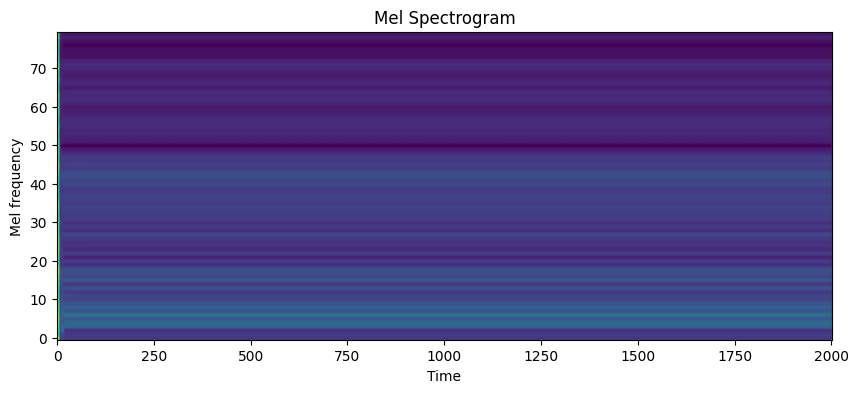

torch.Size([512256])
22050


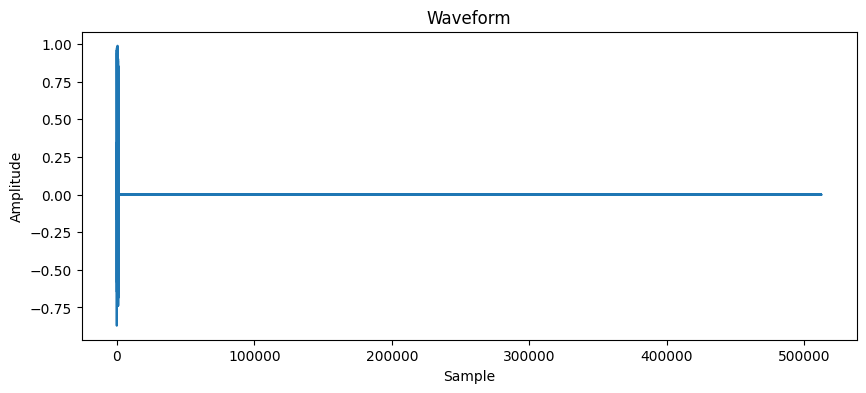

NameError: name 'Audio' is not defined

In [48]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import speechbrain.lobes.models.FastSpeech2 as FastSpeech2

# Load an audio file
audio_file = 'results/TTS_test8_40/1234/generated_waveforms/generated_waveform_1.wav'
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.squeeze(0)
# Generate mel spectrogram
mel_spectrogram, _ = FastSpeech2.mel_spectogram(sample_rate=sample_rate, hop_length=256, win_length=1024, n_fft=1024, n_mels=80, f_min=0.0, f_max=8000, power=1, normalized=False, min_max_energy_norm=True, norm='slaney', mel_scale='slaney', compression=True, audio=waveform)


# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel frequency')
plt.show()


print(waveform.shape)
print(sample_rate)
# Plotting the signal
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#Printing Audio Signal
print()
Audio(waveform, rate=sample_rate)

In [44]:
%%file models.py

import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


def dynamic_batch_collate(batch):
    """
    Collates batches dynamically based on the length of sequences within each batch.
    This function ensures that each batch contains sequences of similar lengths,
    optimizing padding and computational efficiency.

    Args:
        batch: A list of dictionaries, each containing 'id', 'phoneme_seq_encoded',
               'mel_spectrogram', 'mel_length', 'stop_token_targets'.

    Returns:
        A batch of sequences where sequences are padded to match the longest sequence in the batch.
    """
    # Sort the batch by 'mel_length' in descending order for efficient packing
    batch.sort(key=lambda x: x['mel_lengths'], reverse=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Extract sequences and their lengths
    ids = [item['id'] for item in batch]
    phoneme_seqs = [item['phoneme_seq_encoded'] for item in batch]
    mel_specs = [item['mel_spec'] for item in batch]
    #bos_mel_specs = [item['bos_mel_spectrogram'] for item in batch]
    #eos_mel_specs = [item['eos_mel_spectrogram'] for item in batch]
    mel_lengths = torch.tensor([item['mel_lengths'] for item in batch], device=device)
    stop_token_targets = [item['stop_token_targets'] for item in batch]

    # Pad phoneme sequences
    phoneme_seq_padded = torch.nn.utils.rnn.pad_sequence(phoneme_seqs, batch_first=True, padding_value=0).to(device)

    # Find the maximum mel length for padding
    max_len = max(mel_lengths).item()
    num_mel_bins = 80  
    
    mel_specs_padded = torch.zeros((len(mel_specs), num_mel_bins, max_len), device=device)
    for i, mel in enumerate(mel_specs):
        mel_len = mel.shape[1]
        mel_specs_padded[i, :, :mel_len] = mel.to(device)
    
    # # Pad mel spectrograms
    # bos_mel_specs_padded = torch.zeros((len(bos_mel_specs), num_mel_bins, max_len), device=device)
    # for i, mel in enumerate(bos_mel_specs):
    #     mel_len = mel.shape[1]
    #     bos_mel_specs_padded[i, :, :mel_len] = mel.to(device)
    #     
    # eos_mel_specs_padded = torch.zeros((len(eos_mel_specs), num_mel_bins, max_len), device=device)
    # for i, mel in enumerate(eos_mel_specs):
    #     mel_len = mel.shape[1]
    #     eos_mel_specs_padded[i, :, :mel_len] = mel.to(device)

    # Pad stop token targets
    stop_token_targets_padded = torch.zeros((len(stop_token_targets), max_len), device=device)
    for i, stop in enumerate(stop_token_targets):
        stop_len = stop.size(0)
        stop_token_targets_padded[i, :stop_len] = stop.to(device)

    return ids, phoneme_seq_padded, mel_specs_padded, mel_lengths, stop_token_targets_padded


class EncoderPrenet(torch.nn.Module):
     """
    Module for the encoder prenet in the Transformer-based TTS system.

    This module consists of several convolutional layers followed by batch normalization,
    ReLU activation, and dropout. It then performs a linear projection to the desired dimension.

    Parameters:
        input_dim (int): Dimension of the input features. Defaults to 512.
        hidden_dim (int): Dimension of the hidden layers. Defaults to 512.
        num_layers (int): Number of convolutional layers. Defaults to 3.
        dropout (float): Dropout probability. Defaults to 0.2.

    Inputs:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, seq_len, hidden_dim). """
     def __init__(self, input_dim=512, hidden_dim=512, num_layers=3, dropout=0.2):
        super().__init__()

        # Convolutional layers
        conv_layers = []
        for _ in range(num_layers):
            conv_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1))
            conv_layers.append(nn.BatchNorm1d(hidden_dim))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.Dropout(dropout))
        self.conv_layers = nn.Sequential(*conv_layers)

        # Final linear projection
        self.projection = nn.Linear(hidden_dim, hidden_dim)

     def forward(self, x):
        x = x.transpose(1, 2)  # Transpose for convolutional layers (Batch, SeqLen, Channels)
        x = self.conv_layers(x)
        x = x.transpose(1, 2)  # Transpose back
        x = self.projection(x)
        return x
    
    
class DecoderPrenet(torch.nn.Module):
    
    """
    Module for the decoder prenet in the Transformer-based TTS system.

    This module consists of two fully connected layers followed by ReLU activation,
    and performs a linear projection to the desired output dimension.

    Parameters:
        input_dim (int): Dimension of the input features. Defaults to 80.
        hidden_dim (int): Dimension of the hidden layers. Defaults to 256.
        output_dim (int): Dimension of the output features. Defaults to 512.

    Inputs:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, seq_len, output_dim). """
    
    def __init__(self, input_dim=80, hidden_dim=256, output_dim=512):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.transpose(1,2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.projection(x)

        return x
    

class ScaledPositionalEncoding(nn.Module):
    
    """
    Module for adding scaled positional encoding to input sequences.

    Parameters:
        d_model (int): Dimensionality of the model. It must match the embedding dimension of the input.
        max_len (int): Maximum length of the input sequence. Defaults to 5000.

    Inputs:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_len, embedding_dim).

    Returns:
        torch.Tensor: Output tensor with scaled positional encoding added, shape (batch_size, seq_len, embedding_dim). """
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        """
        Adds scaled positional encoding to input tensor x.
        Args:
            x: Tensor of shape [batch_size, seq_len, embedding_dim]
        """
        scaled_pe = self.pe[:x.size(0), :, :] * self.scale
        x = x + scaled_pe
        return x

    
class PostNet(torch.nn.Module):
    
    """
    Post-processing network for mel-spectrogram enhancement.

    This module consists of multiple convolutional layers with batch normalization and ReLU activation.
    It is used to refine the mel-spectrogram output from the decoder.

    Parameters:
        mel_channels (int): Number of mel channels in the input mel-spectrogram.
        postnet_channels (int): Number of channels in the postnet layers.
        kernel_size (int): Size of the convolutional kernel.
        postnet_layers (int): Number of postnet layers.

    Inputs:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_len, mel_channels).

    Returns:
        torch.Tensor: Output tensor with refined mel-spectrogram, shape (batch_size, seq_len, mel_channels). """

    
    def __init__(self, mel_channels, postnet_channels, kernel_size, postnet_layers):
        super().__init__()
        self.conv_layers = nn.ModuleList()
        
        # First layer
        self.conv_layers.append(
            nn.Sequential(
                nn.Conv1d(mel_channels, postnet_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(postnet_channels),
                nn.ReLU()
            )
        )
        
        # Middle layers
        for _ in range(1, postnet_layers - 1):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv1d(postnet_channels, postnet_channels, kernel_size, padding=kernel_size // 2),
                    nn.BatchNorm1d(postnet_channels),
                    nn.ReLU()
                )
            )
        
        # Final layer
        self.conv_layers.append(
            nn.Sequential(
                nn.Conv1d(postnet_channels, mel_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(mel_channels)
            )
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        for conv in self.conv_layers:
            x = conv(x)
        x = x.transpose(1, 2)
        return x

Overwriting models.py


In [1]:
%%file hparams_train.yaml

###################################
# Experiment Parameters and setup #
###################################
seed: 1234
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/TTS_test32_30_nhead4/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
max_grad_norm: 1.0
progress_samples: False
progress_sample_path: !ref <output_folder>/samples
progress_samples_min_run: 10
progress_samples_interval: 10
progress_batch_sample_size: 1
test_batch_sample_size: 4 #saves this for every batch


#################################
# Data files and pre-processing #
#################################
data_folder: !ref LJSpeech-1.1
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/small_test.json


################################
# Audio Parameters             #
################################
sample_rate: 22050
hop_length: 256
win_length: 1024
n_mel_channels: 80
n_fft: 1024
mel_fmin: 0.0
mel_fmax: 8000.0
power: 1
normalized: False
min_max_energy_norm: True
norm: "slaney"
mel_scale: "slaney"
dynamic_range_compression: True
mel_normalized: False
min_f0: 65  #(torchaudio pyin values)
max_f0: 2093 #(torchaudio pyin values)


################################
# Optimization Hyperparameters #
################################
learning_rate: 0.0001
weight_decay: 0.000001
batch_size: 32
num_workers_train: 0
num_workers_valid: 0
betas: [0.9, 0.98]
stop_threshold: 0.5
number_of_epochs: 30
pos_weight: 5.0

###################################
# Stage related Parameters #
###################################
stage_one_epochs: 100
lr_adam: 0.0001
lr_sgd: 0.00003
lexicon:
    - AA
    - AE
    - AH
    - AO
    - AW
    - AY
    - B
    - CH
    - D
    - DH
    - EH
    - ER
    - EY
    - F
    - G
    - HH
    - IH
    - IY
    - JH
    - K
    - L
    - M
    - N
    - NG
    - OW
    - OY
    - P
    - R
    - S
    - SH
    - T
    - TH
    - UH
    - UW
    - V
    - W
    - Y
    - Z
    - ZH
    - ' '

n_symbols: 42 #fixed depending on symbols in the lexicon +1 for a dummy symbol used for padding
padding_idx: 0

# Define model architecture
d_model: 512
nhead: 4
num_encoder_layers: 6
num_decoder_layers: 6
dim_feedforward: 2048
dropout: 0.2
blank_index: 0 # This special token is for padding
bos_index: 1
eos_index: 2
stop_weight: 0.45


###################################
# Model and Components #
###################################
enc_pre_net: !new:models.EncoderPrenet
dec_pre_net: !new:models.DecoderPrenet


encoder_emb: !new:torch.nn.Embedding
    num_embeddings: 128
    embedding_dim: !ref <d_model>
    padding_idx: !ref <blank_index>

pos_emb_enc: !new:models.ScaledPositionalEncoding
    d_model: !ref <d_model>


pos_emb_dec: !new:models.ScaledPositionalEncoding
    d_model: !ref <d_model>
    
Seq2SeqTransformer: !new:torch.nn.Transformer
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    dim_feedforward: !ref <dim_feedforward>
    dropout: !ref <dropout>
    batch_first: True

postnet: !new:models.PostNet
    mel_channels: !ref <n_mel_channels>
    postnet_channels: 512
    kernel_size: 5
    postnet_layers: 5

mel_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <n_mel_channels>

stop_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: 1

#ckpt_enable: True
#ckpt_interval_minutes: 0.01
# Masks
lookahead_mask: !name:speechbrain.lobes.models.transformer.Transformer.get_lookahead_mask
padding_mask: !name:speechbrain.lobes.models.transformer.Transformer.get_key_padding_mask

mel_spec_feats: !name:speechbrain.lobes.models.FastSpeech2.mel_spectogram
    sample_rate: !ref <sample_rate>
    hop_length: !ref <hop_length>
    win_length: !ref <win_length>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mel_channels>
    f_min: !ref <mel_fmin>
    f_max: !ref <mel_fmax>
    power: !ref <power>
    normalized: !ref <normalized>
    min_max_energy_norm: !ref <min_max_energy_norm>
    norm: !ref <norm>
    mel_scale: !ref <mel_scale>
    compression: !ref <dynamic_range_compression>

modules:
    enc_pre_net: !ref <enc_pre_net>
    encoder_emb: !ref <encoder_emb>
    pos_emb_enc: !ref <pos_emb_enc>

    dec_pre_net: !ref <dec_pre_net>
    #decoder_emb: !ref <decoder_emb>
    pos_emb_dec: !ref <pos_emb_dec>

    Seq2SeqTransformer: !ref <Seq2SeqTransformer>
    postnet: !ref <postnet>
    mel_lin: !ref <mel_lin>
    stop_lin: !ref <stop_lin>

model: !new:torch.nn.ModuleList
    - [!ref <enc_pre_net>, !ref <encoder_emb>, !ref <pos_emb_enc>, !ref <dec_pre_net>, !ref <pos_emb_dec>, !ref <Seq2SeqTransformer>, !ref <postnet>, !ref <mel_lin>, !ref <stop_lin>]


###################################
# Error stats and Data Loaders #
###################################

mel_error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.mse_loss
        reduction: batch

stop_error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.bce_loss
        reduction: batch

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    drop_last: False  #True #False
    num_workers: !ref <num_workers_train>
    shuffle: True
    collate_fn: !name:models.dynamic_batch_collate

valid_dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: !ref <num_workers_valid>
    shuffle: False
    collate_fn: !name:models.dynamic_batch_collate

test_dataloader_opts:
    batch_size: !ref <batch_size>
    collate_fn: !name:models.dynamic_batch_collate


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

stop_loss: !name:speechbrain.nnet.losses.bce_loss

mel_loss: !name:speechbrain.nnet.losses.mse_loss

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 4000

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    weight_decay: !ref <weight_decay>
    betas: !ref <betas>
    eps: 0.000000001

SGD: !name:torch.optim.SGD
    lr: !ref <lr_sgd>
    momentum: 0.99
    nesterov: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        optimizer: !ref <opt_class>
        lr_annealing: !ref <noam_annealing>
        counter: !ref <epoch_counter>


progress_sample_logger: !new:speechbrain.utils.train_logger.ProgressSampleLogger
    output_path: !ref <progress_sample_path>
    batch_sample_size: !ref <progress_batch_sample_size>
    formats:
        raw_batch: raw

Overwriting hparams_train.yaml


In [67]:
%%file train.py
#!/usr/bin/env/python3


import os
import sys
import torch
import pickle
import warnings
import torch
import torch as nn
import torch.nn.functional as F
import torchaudio
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.inference.text import GraphemeToPhoneme
from speechbrain.inference.vocoders import HIFIGAN


logger = logging.getLogger(__name__)


# Brain class for TTS training
class TTS(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def save_scale_values(self):
        """
            Saves the scale values of the encoder and decoder modules to pickle files.
            These scale values are used for tracking the scaling factors applied during
            the training process, which can be useful for analysis and debugging purposes."""
        def append_to_file(file_path, data):
            """
                    Appends data to a file using pickle serialization.

                    Parameters:
                        file_path (str): The path to the file where data will be appended.
                        data (any): The data to be appended to the file.

            """

            # Write the updated data back to the file
            with open(file_path, 'ab') as file:
                pickle.dump(data, file)

        # Paths for the encoder and decoder scale values
        encoder_file_path = os.path.join(self.hparams.save_folder, 'encoder_scale_values.pkl')
        decoder_file_path = os.path.join(self.hparams.save_folder, 'decoder_scale_values.pkl')

        # Append scale values to their respective files
        append_to_file(encoder_file_path, self.encoder_scale_values)
        append_to_file(decoder_file_path, self.decoder_scale_values)

        # Reset the lists of new values after saving
        self.new_encoder_scale_values = []
        self.new_decoder_scale_values = []

    def remember_samples(self, mel_output, mel_length):
        # Store predictions; adapt based on your actual output format
        self.remembered_samples.append((mel_output, mel_length))

    def should_remember(self, epoch):
        # Determines if samples should be remembered based on the current epoch and log interval
        return (self.hparams.progress_samples and
                epoch % self.hparams.progress_samples_interval == 0 and
                epoch >= self.hparams.progress_samples_min_run)

    def log_remembered_samples(self,stage, epoch):
        # Iterate through remembered samples to save them
        vocoder = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech",
                                       savedir="pretrained_models/hifi-gan-ljspeech")

        for i, (mel_output, mel_length) in enumerate(self.remembered_samples):

            waveform = vocoder.decode_batch(mel_output.to(self.device), mel_length,
                                            hop_len=self.hparams.hop_length )

            filename = f"{stage}_epoch{epoch}_{i}.wav"
            filepath = os.path.join(self.hparams.progress_sample_logger.output_path, filename)
            torchaudio.save(filepath, waveform.squeeze(1), self.hparams.sample_rate)

        # Optionally, clear remembered samples to save memory
        self.remembered_samples.clear()

    @torch.no_grad()
    def inference(self, encoder_emb, initial_input, max_generation_length=1000):
        """
            Performs inference to generate mel spectrograms using the trained model.

            This function generates mel spectrograms by iteratively decoding the input mel spectrogram
            and stopping when a predefined stop condition is met or the maximum generation length is reached.

            Parameters:
                encoder_emb (torch.Tensor): The encoded input phoneme sequence.
                initial_input (torch.Tensor): The initial input mel spectrogram for decoding.
                max_generation_length (int): The maximum length of the generated mel spectrogram sequence. Defaults to 1000.

            Returns:
                stop_tokens_logits (torch.Tensor): Logits indicating the stop tokens generated during inference.
                results (torch.Tensor): The concatenated tensor containing the generated mel spectrogram sequence. """

        stop_generated = False
        decoder_input = initial_input
        stop_tokens_logits = []
        sequence_length = 0

        result = []
        result.append(decoder_input)

        src_mask = torch.zeros(encoder_emb.size(1), encoder_emb.size(1), device=self.device)
        src_key_padding_mask = self.hparams.padding_mask(encoder_emb, self.hparams.blank_index)


        while not stop_generated and sequence_length < max_generation_length:
            encoded_mel = self.modules.dec_pre_net(decoder_input)
            pos_emb_dec = self.modules.pos_emb_dec(encoded_mel)
            decoder_emb = encoded_mel + pos_emb_dec

            decoder_output = self.modules.Seq2SeqTransformer(
                encoder_emb, decoder_emb, src_mask=src_mask,
                src_key_padding_mask=src_key_padding_mask)

            mel_output = self.modules.mel_lin(decoder_output)

            stop_token_logit = self.modules.stop_lin(decoder_output).squeeze(-1)

            post_mel_outputs = self.modules.postnet(mel_output.to(self.device))
            refined_mel_output = mel_output + post_mel_outputs.to(self.device)
            refined_mel_output = refined_mel_output.transpose(1, 2)

            stop_tokens_logits.append(stop_token_logit)
            stop_token_probs = torch.sigmoid(stop_token_logit)

            if torch.any(stop_token_probs[:, -1] >= self.hparams.stop_threshold):
                stop_generated = True

            decoder_input = refined_mel_output
            result.append(decoder_input)
            sequence_length += 1

        results = torch.cat(result, dim=2)
        stop_tokens_logits = torch.cat(stop_tokens_logits, dim=1)

        return stop_tokens_logits, results

    def compute_forward(self, batch, stage):
        """Runs the forward pass of the model to compute predictions.

        Arguments
        ---------
        batch : PaddedBatch
            The batch object containing input tensors.
        stage : sb.Stage
            The stage of training: sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : Tuple[torch.tensor, torch.tensor]
            Predicted stop token logits and refined mel spectrogram outputs.

        At validation/test time, it returns the predicted tokens as well.
            """

        id, phoneme_seq_padded, mel_specs_padded, mel_lengths, stop_token_targets_padded = batch

        encoded_phoneme = self.modules.encoder_emb(phoneme_seq_padded)
        encoder_emb = self.modules.enc_pre_net(encoded_phoneme)
        encoder_emb = encoder_emb + self.modules.pos_emb_enc(encoded_phoneme)

        if stage == sb.Stage.TEST:
            initial_input = torch.zeros(mel_specs_padded.shape[0], 80, 1, device=self.device)
            stop_tokens_logits, refined_mel_outputs = self.inference( encoder_emb, initial_input)

            vocoder = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech",
                                           savedir="pretrained_models/hifi-gan-ljspeech")
            seq_len = refined_mel_outputs.shape[2]  # The common length of all sequences if they are uniform.
            mel_lengths = torch.full((refined_mel_outputs.shape[0],), seq_len, dtype=torch.long, device=refined_mel_outputs.device)
            limited_ids = id[:self.hparams.test_batch_sample_size]
            limited_mel_outputs = refined_mel_outputs[:self.hparams.test_batch_sample_size]
            limited_mel_lengths = mel_lengths[:self.hparams.test_batch_sample_size]

            # Generate waveforms from mel spectrograms
            generated_waveforms = vocoder.decode_batch(limited_mel_outputs.to(self.device),
                                                      limited_mel_lengths, hop_len=self.hparams.hop_length)

            base_path = os.path.join(self.hparams.output_folder, "generated_waveforms")

            # Assuming hop_length and sample_rate are defined in your hparams
            hop_length = self.hparams.hop_length
            sample_rate = self.hparams.sample_rate

            for i, (waveform, mel_length) in enumerate(zip(generated_waveforms, limited_mel_lengths)):
                # Calculate the original audio length
                original_length = mel_length * hop_length

                # Truncate the waveform to the original length
                waveform = waveform[:, :original_length]

                os.makedirs(base_path, exist_ok=True)
                file_path = os.path.join(base_path, f"generated_waveform_{i}.wav")
                torchaudio.save(file_path, waveform.squeeze(1), sample_rate)

            logger.info(f"Saved samples per batch from the test set.")

        else:

            decoder_input = torch.cat([torch.zeros_like(mel_specs_padded[:, :, :1]), mel_specs_padded[:, :, :-1]],dim=2)
            encoded_mel = self.modules.dec_pre_net(decoder_input)
            pos_emb_dec = self.modules.pos_emb_dec(encoded_mel)
            decoder_emb = encoded_mel + pos_emb_dec

            # Log the scale values
            self.encoder_scale_values.append(self.modules.pos_emb_enc.scale.item())
            self.decoder_scale_values.append(self.modules.pos_emb_dec.scale.item())

            # Masking
            tgt_mask = self.hparams.lookahead_mask(decoder_emb)
            src_mask = torch.zeros(encoder_emb.shape[1], encoder_emb.shape[1], device=self.device)
            src_key_padding_mask = self.hparams.padding_mask(encoder_emb, self.hparams.blank_index)
            tgt_key_padding_mask = self.hparams.padding_mask(decoder_emb, self.hparams.blank_index)

            # Transformer
            decoder_outputs = self.modules.Seq2SeqTransformer(encoder_emb, decoder_emb, src_mask=src_mask,
                                                              tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                                              tgt_key_padding_mask=tgt_key_padding_mask)

            # Post-net computations
            mel_outputs = self.modules.mel_lin(decoder_outputs)
            stop_tokens_logits = self.modules.stop_lin(decoder_outputs).squeeze(-1)
            post_mel_outputs = self.modules.postnet(mel_outputs.to(self.device))
            refined_mel_outputs = mel_outputs + post_mel_outputs.to(self.device)
            refined_mel_outputs = refined_mel_outputs.transpose(1,2)

            if stage == sb.Stage.VALID and self.should_remember(self.hparams.epoch_counter.current):
                self.remember_samples(refined_mel_outputs, mel_lengths)

        return (stop_tokens_logits, refined_mel_outputs)


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : torch.Tensor
            The model generated spectrograms and other metrics from `compute_forward`.
        batch : PaddedBatch

            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Unpack the predictions
        stop_tokens_logits, refined_mel_outputs = predictions
        id, phoneme_seq_padded, mel_specs_padded, mel_lengths, stop_token_targets_padded = batch

        stop_loss = self.hparams.stop_loss(stop_tokens_logits, stop_token_targets_padded, mel_lengths, pos_weight=torch.tensor([self.hparams.pos_weight], device=self.device))
        mel_loss = self.hparams.mel_loss(refined_mel_outputs.float(), mel_specs_padded.float(), mel_lengths)

        #Option1
        loss = stop_loss + mel_loss

        #Option2
        # loss = (
        #         self.hparams.stop_weight * stop_loss
        #         + (1 - self.hparams.stop_weight) * mel_loss
        # )

        self.last_loss_stats[stage] = {
            "total_loss": loss.item(),
            "stop_loss": stop_loss.item(),
            "mel_loss": mel_loss.item()
        }

        if stage != sb.Stage.TRAIN:
            self.mel_error_metrics.append(id, refined_mel_outputs.float(), mel_specs_padded.float())
            self.stop_error_metrics.append(id, stop_tokens_logits, stop_token_targets_padded)

        return loss

    def on_fit_batch_start(self, batch, should_step):
        """Gets called at the beginning of each fit_batch."""
        # check if we need to switch optimizer
        # if so change the optimizer from Adam to SGD
        self.check_and_reset_optimizer()

    def on_fit_batch_end(self, batch, outputs, loss, should_step):
        """At the end of the optimizer step, apply noam annealing."""
        if should_step:
            self.hparams.noam_annealing(self.optimizer)

    def on_stage_start(self, stage, epoch=None):
        """Called at the beginning of each epoch, sets up metrics"""
        if stage != sb.Stage.TRAIN:
            self.mel_error_metrics = self.hparams.mel_error_stats()
            self.stop_error_metrics = self.hparams.stop_error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Performs actions at the end of each stage of training/validation/testing.

            Arguments
            ---------
            stage : sb.Stage
                The stage of training: sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
            stage_loss : float
                The loss value computed for the stage.
            epoch : int or None, optional
                The current epoch number. Defaults to None.

            At the end of training stage, it saves the scale values and logs training statistics.
            At the end of validation stage, it logs validation statistics, saves predicted samples if required,
            and performs model checkpointing based on the `mel_error`.
            At the end of testing stage, it logs testing statistics.
            """
        stage_stats = self.last_loss_stats[stage]
        current_epoch = self.hparams.epoch_counter.current

        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
            self.save_scale_values()

        else:
            stage_stats["mel_error"] = self.mel_error_metrics.summarize("average")
            stage_stats["stop_error"] = self.stop_error_metrics.summarize("average")

        if stage == sb.Stage.VALID:
            if current_epoch <= self.hparams.stage_one_epochs:
                lr = self.hparams.noam_annealing.current_lr
                steps = self.hparams.noam_annealing.n_steps
                optimizer = self.optimizer.__class__.__name__
            else:
                lr = self.hparams.lr_sgd
                steps = -1
                optimizer = self.optimizer.__class__.__name__

            # Log training and validation statistics
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": lr, "optimizer": optimizer},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )

            # Save predicted samples if required
            if self.should_remember(epoch):
                logger.info("Saving predicted samples")
                self.log_remembered_samples(stage, epoch)
                self.remembered_samples = []

            # Model checkpointing based on mel_error
            self.checkpointer.save_and_keep_only(meta=stage_stats, min_keys=["mel_error"])

        elif stage == sb.Stage.TEST:
            # Log testing statistics
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=self.last_loss_stats[sb.Stage.TEST],
            )

    def check_and_reset_optimizer(self):
        """reset the optimizer if training enters stage 2"""
        current_epoch = self.hparams.epoch_counter.current
        if not hasattr(self, "switched"):
            self.switched = False
            if isinstance(self.optimizer, torch.optim.SGD):
                self.switched = True

        if self.switched is True:
            return

        if current_epoch > self.hparams.stage_one_epochs:
            self.optimizer = self.hparams.SGD(self.modules.parameters())

            if self.checkpointer is not None:
                self.checkpointer.add_recoverable("optimizer", self.optimizer)

            self.switched = True

    def on_fit_start(self):
        """Gets called at the beginning of ``fit()``, on multiple processes
        if ``distributed_count > 0`` and backend is ddp and initializes statistics
        """
        self.hparams.progress_sample_logger.reset()
        self.last_epoch = 0

        self.encoder_scale_values = []
        self.decoder_scale_values = []

        self.last_loss_stats = {}
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        os.makedirs(self.hparams.progress_sample_logger.output_path, exist_ok=True)
        self.remembered_samples = []

        return super().on_fit_start()

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """


    @sb.utils.data_pipeline.takes("phoneme_seq")
    @sb.utils.data_pipeline.provides("phoneme_seq_encoded_lst", "phoneme_seq_encoded")
    def text_pipeline(phoneme_seq):
        """Processes the transcriptions to generate proper labels"""

        phoneme_seq_encoded_lst = label_encoder.encode_sequence(phoneme_seq)
        yield phoneme_seq_encoded_lst
        phoneme_seq_encoded = torch.LongTensor(phoneme_seq_encoded_lst)
        yield phoneme_seq_encoded

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("mel_spec", "mel_lengths", "stop_token_targets")
    def mel_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)
        sig = sig.squeeze(0)
        mel_spec, _ = hparams['mel_spec_feats'](audio=sig)
        # Initialize BOS and EOS tokens as additional "time steps" with the chosen values
        #bos_token = torch.ones(80, 1)
        #eos_token = torch.full((80, 1), 2)

        # Concatenate BOS token, actual mel spectrogram, and EOS token
        #bos_mel_spectrogram = torch.cat([bos_token, mel_spec], dim=1)
        #eos_mel_spectrogram = torch.cat([mel_spec, eos_token], dim=1)

        # Update the mel length to include BOS and EOS tokens
        #mel_lengths = bos_mel_spectrogram.shape[1]

        # Calculate lengths and stop tokens
        mel_lengths = mel_spec.shape[1]  # [n_mels, time] -> time
        stop_token_targets = torch.zeros(mel_lengths)
        stop_token_targets[-1:] = 1  # The last frame should have the stop token
        return mel_spec, mel_lengths, stop_token_targets

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }

    # The label encoder will assign a different integer to each element
    # in the output vocabulary
    label_encoder = sb.dataio.encoder.TextEncoder()
    label_encoder.update_from_iterable(hparams["lexicon"], sequence_input=False)
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[text_pipeline, mel_pipeline],
            output_keys=[
                "id",
                "phoneme_seq_encoded_lst",
                "phoneme_seq_encoded",

                "mel_spec",
                "mel_lengths",
                "stop_token_targets",

            ],
        )

        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True

    # Load or compute the label encoder
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    special_labels = {
        "blank_label": hparams["blank_index"],
        "bos_label": hparams["bos_index"],
        "eos_label": hparams["eos_index"],
    }
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="phoneme_seq",
        special_labels=special_labels,
        sequence_input=True,
    )

    return datasets, label_encoder


if __name__ == "__main__":
    # Reading command line arguments

    warnings.filterwarnings("ignore")
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # We can now directly create the datasets for training, valid, and test
    datasets, label_encoder = dataio_prepare(hparams)

    # Trainer initialization
    TTS_brain = TTS(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Making label encoder accessible (needed for computer the character error rate)
    TTS_brain.label_encoder = label_encoder

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the pointpointer, training can be
    # stopped at any point, and will be resumed on next call.
    TTS_brain.fit(
        TTS_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # After fit() completes, save the scale values
    #TTS_brain.save_scale_values()

    # Load best checkpoint for evaluation
    test_stats = TTS_brain.evaluate(
        test_set=datasets["test"],
        min_key="combined loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting train.py


In [ ]:
!python train.py hparams_train.yaml --device='cuda'

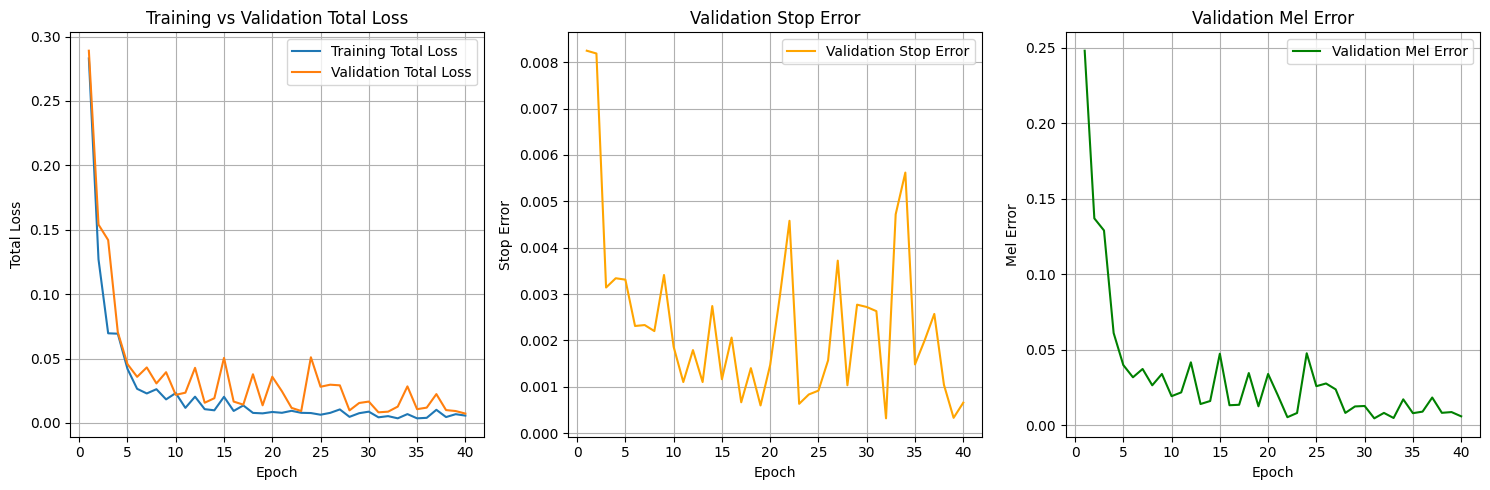

In [16]:
import matplotlib.pyplot as plt
import re

# Initialize lists to hold the extracted data
epochs = []
train_losses = []
valid_losses = []
valid_stop_errors = []
valid_mel_errors = []

with open('results/TTS_test8_40/1234/train_log.txt', 'r') as file:
    for line in file:
        # Use regular expression to find the epoch number and loss values
        epoch_match = re.search(r'epoch: (\d+)', line)
        train_loss_match = re.search(r'train total_loss: ([\d.e-]+)', line)
        valid_loss_match = re.search(r'valid total_loss: ([\d.e-]+)', line)
        valid_stop_error_match = re.search(r'valid stop_error: ([\d.e-]+)', line)
        valid_mel_error_match = re.search(r'valid mel_error: ([\d.e-]+)', line)
        
        # If matches are found, append the data to the lists
        if epoch_match:
            epochs.append(int(epoch_match.group(1)))
        if train_loss_match:
            train_losses.append(float(train_loss_match.group(1)))
        if valid_loss_match:
            valid_losses.append(float(valid_loss_match.group(1)))
        if valid_stop_error_match:
            valid_stop_errors.append(float(valid_stop_error_match.group(1)))
        if valid_mel_error_match:
            valid_mel_error = float(valid_mel_error_match.group(1))
            valid_mel_errors.append(valid_mel_error)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots: 1 row, 3 columns

# Training and Validation Total Loss
axs[0].plot(epochs, train_losses, label='Training Total Loss')
axs[0].plot(epochs, valid_losses, label='Validation Total Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Total Loss')
axs[0].set_title('Training vs Validation Total Loss')
axs[0].legend()
axs[0].grid(True)

# Validation Stop Error
axs[1].plot(epochs, valid_stop_errors, label='Validation Stop Error', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Stop Error')
axs[1].set_title('Validation Stop Error')
axs[1].legend()
axs[1].grid(True)

# Validation Mel Error
axs[2].plot(epochs, valid_mel_errors, label='Validation Mel Error', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Mel Error')
axs[2].set_title('Validation Mel Error')
axs[2].legend()
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

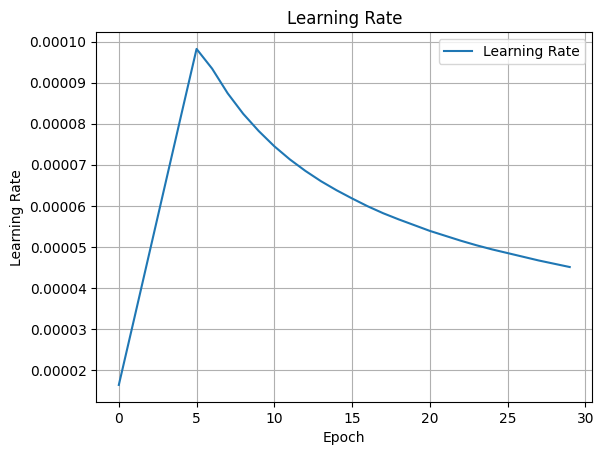

In [61]:
import matplotlib.pyplot as plt
import re

# Initialize lists to hold the extracted data
epochs = []
lr = []


# Read the log file and extract the necessary data
with open('results/TTS_test16_30/1234/train_log.txt', 'r') as file:
    for line in file:
        # Use regular expression to find the epoch number and loss values
        #epoch_match = re.search(r'epoch: (\d+)', line)
        lr_match = re.search(r'lr: ([\d.e-]+)', line)
        
        
        # If matches are found, append the data to the lists
        if lr_match:
            #epochs.append(int(epoch_match.group(1)))
            lr.append(float(lr_match.group(1)))

# Plotting
plt.plot( lr, label='Learning Rate')

plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

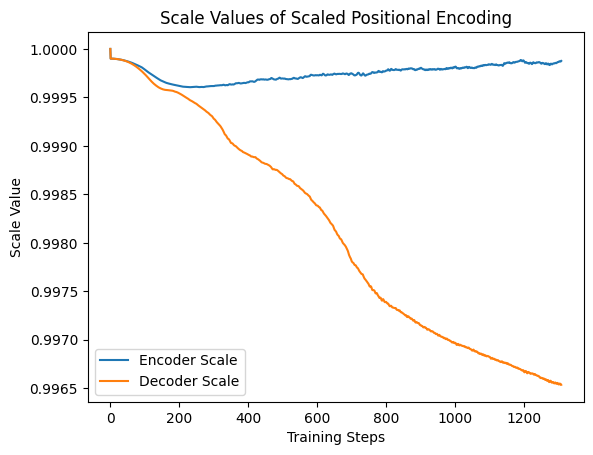

In [2]:
import pickle
import matplotlib.pyplot as plt

# Load scale values
with open('results/TTS_test8_40_nhead4/1234/save/encoder_scale_values.pkl', 'rb') as f:
    encoder_scale_values = pickle.load(f)

with open('results/TTS_test8_40_nhead4/1234/save/decoder_scale_values.pkl', 'rb') as f:
    decoder_scale_values = pickle.load(f)

# Plotting
plt.plot(encoder_scale_values, label='Encoder Scale')
plt.plot(decoder_scale_values, label='Decoder Scale')
plt.xlabel('Training Steps')
plt.ylabel('Scale Value')
plt.title('Scale Values of Scaled Positional Encoding')
plt.legend()
plt.show()